# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Imports Lib.

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import ipywidgets
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

print("lib loading done!")

lib loading done!


In [2]:
# load camera calibration data
calibration = pickle.load(open("calibration.p", "rb" ))
mtx = calibration['mtx']
dist = calibration['dist']

print("calibration data loading done!")

calibration data loading done!


### The process of verifying that the result of the calibration process is successful

undistorted processing done!


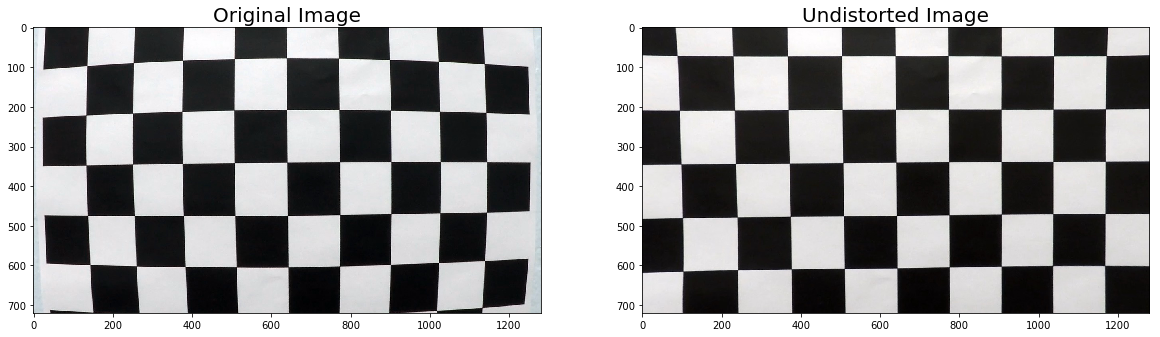

In [3]:
# Test undistortion function
img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
# save undistorte
cv2.imwrite("./output_images/Undistorted_calibration1.jpg", dst)

print("undistorted processing done!")

### Image used for examination of parameter setting value

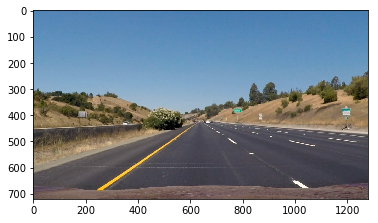

In [4]:
# Image for parameter adjustment
sampleImage = cv2.imread('./test_images/straight_lines1.jpg')
sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)
plt.imshow(sampleImage)

### Strain correction processing

In [5]:
def undistort(img):
    """
    Strain Correction Function
    """   
    return cv2.undistort(img, mtx, dist, None, mtx)

#### Image before and after distortion correction processing

undistorted processing done!


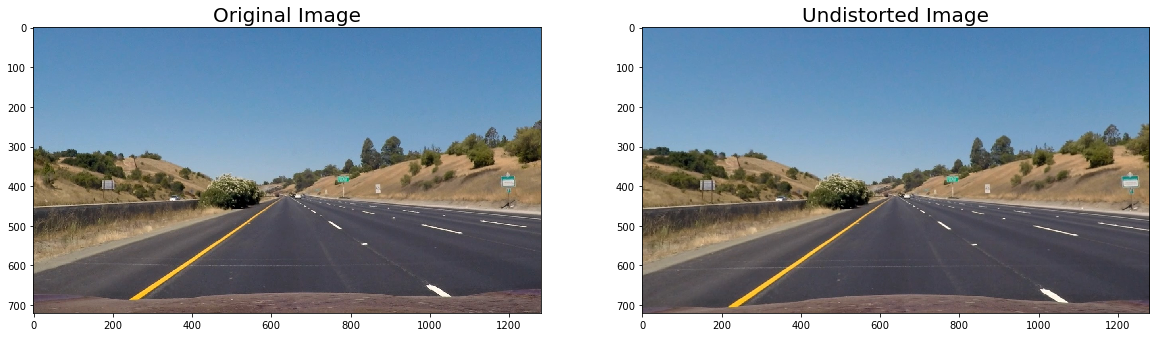

In [6]:
sampleImage_undistort = undistort(sampleImage)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(sampleImage)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sampleImage_undistort)
ax2.set_title('Undistorted Image', fontsize=20)

print("undistorted processing done!")

### Perspective transform

In [7]:
def exec_warp(img, src, dst):
    h,w = img.shape[:2]

    # calculate the tranceform matrix(M) and inverse tranceform matrix(Minv)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # tranceform normal view image to bird's eye view image
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

** Visualize perspective transform on example image **

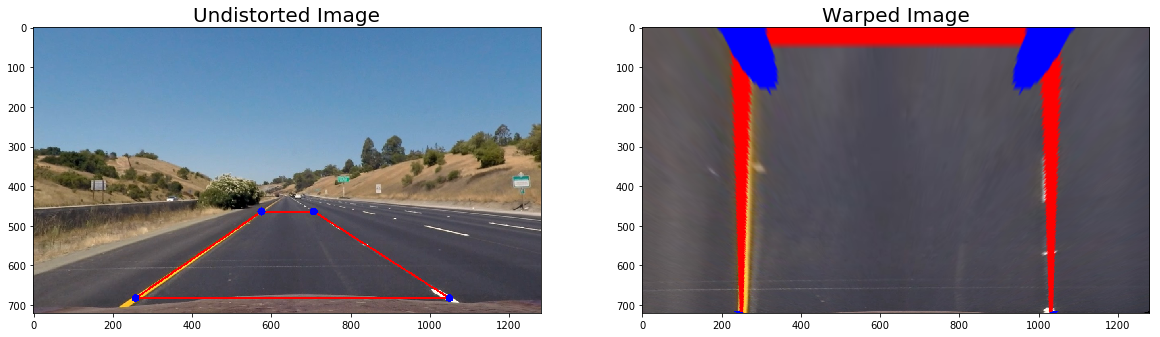

In [8]:
h,w = sampleImage_undistort.shape[:2]

h_offset = 0     # height offset
w_offset = 250   # width offset

# define source and destination points for transform

# src point setting
src = np.float32([( 707,464), 
                  (1049,682),
                  ( 258,682), 
                  ( 575,464)])
# dst point setting
dst = np.float32([[w-w_offset, h_offset], 
                  [w-w_offset, h-h_offset], 
                  [w_offset, h-h_offset],
                  [w_offset, h_offset]])

# copy image and draw src points
paint = sampleImage_undistort.copy()   
vertices = np.int_([src])
cv2.polylines(paint, [vertices], 1, (255,0,0), 4)    
for point in src:
    new_point = tuple(point.astype(np.int))
    cv2.circle(paint, new_point, 10, (0,0,255), -1) 
    
# Visualize process
# visualize undistoted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(paint)
ax1.set_title('Undistorted Image', fontsize=20)

# create unwarped image and save mat data for unwaped
sampleImage_warp, M, Minv = exec_warp(paint, src, dst)

perspective_mat = {'M': M, 'Minv': Minv}
pickle.dump(perspective_mat, open("./perspective_mat.p", "wb"))

ax2.imshow(sampleImage_warp)
ax2.set_title('Warped Image', fontsize=20)


### Process of efficiently extracting lanes using color space and gradient and direction detection

#### HLS Color Space Thresholding process

In [9]:
def det_lines_by_hls_color(rgb_image, w_low_th, w_up_th, y_low_th, y_up_th):
    """
    Convert rgb color space to hls color space and extract white and yellow lines individually. 
    By fusing the two extraction results, lanes of both colors can be detected efficiently.
    """

    # convert rgb to hls
    hls_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)

    white = cv2.inRange(hls_image, w_low_th, w_up_th)  # extract white line
    yellow = cv2.inRange(hls_image, y_low_th, y_up_th) # extract yellow line 
    col_combined = yellow | white # Merge results
    
    return col_combined

#### Sobel Mag. and Dir. Threshold Process

In [10]:
# Process of combining color space and gradient result
def proc_dilate(image):
    """
    Filtering process to extend extraction results
    """
    element = np.ones((3,3), np.uint8)
    return cv2.dilate(image, element, iterations=4)

def combine_color_and_gradient(col_th_result, grad_th_result):
    """
    Process of combining color space and gradient result
    """
    combined_result = col_th_result & proc_dilate(grad_th_result)
    
    element = np.ones((3,3), np.uint8)
    eroded = cv2.erode(combined_result, element, iterations=1) # Remove image noise and whiskers
    dilated = cv2.dilate(eroded, element, iterations=2)        # Supplementing defective parts of images
    
    return dilated

In [11]:
def det_lines_by_sobel(rgb_image, sobel_mag_th, sobel_ang_th):
    """
    A function that calculates the gradient in the x and y directions using the sobel filter
    and extracts the result only in the limited direction
    """
    # convert rgb to hls
    hls_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    
    # s channel
    s_channel = hls_image[:,:,2]
    
    # Sobel x
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    
    # Sobel y
    sobel_y = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobel_y = np.absolute(sobel_y) # Absolute x derivative to accentuate lines away from horizontal
    
    # calc mag and angle of grad
    mag = np.sqrt(sobel_x*sobel_x + sobel_y*sobel_y)
    mag_img = (255*mag/np.max(mag)).astype(np.uint8)
    # The magnitude of change in pixel value in the horizontal direction:abs_sobel_x
    # The magnitude of change in pixel value in the vertical direction:abs_sobel_y
    # For the above reasons, the arguments are as follows.
    sobel_ang = np.arctan2(abs_sobel_x, abs_sobel_y)
    
    # Threshold of gradient and direction
    sobel_binary = np.zeros_like(sobel_x, np.uint8)
    sobel_binary[(mag_img >= sobel_mag_th[0]) & (mag_img <= sobel_mag_th[1]) & \
                 (sobel_ang >= sobel_ang_th[0]) & (sobel_ang <= sobel_ang_th[1])] = 1
    
    return sobel_binary

### Setting value review process

##### The result of converting the sample image (RGB) into the HLS color space is shown below.

(-0.5, 1279.5, 719.5, -0.5)

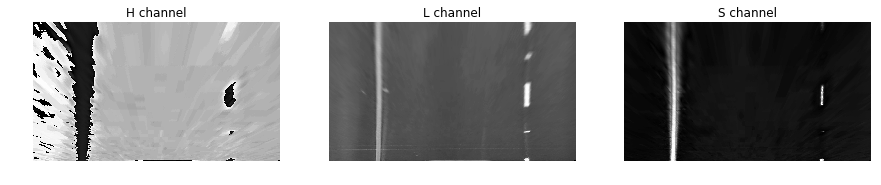

In [12]:
sampleImage_warp, M, Minv = exec_warp(sampleImage_undistort, src, dst)
hls = cv2.cvtColor(sampleImage_warp, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[...,1]
s = hls[...,2]

plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
plt.imshow(h, cmap='gray')
plt.title("H channel")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(l, cmap='gray')
plt.title("L channel")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(s, cmap='gray')
plt.title("S channel")
plt.axis('off')

#### For the HLS image, the line is extracted by performing threshold processing on the color information, the gradient and its direction. The threshold decision process of each process is as follows.

###### Threshold processing using color information

In [13]:
# detection while or yellow lines for(trial func)
def hls_prm_adj_proc(hls, lower, upper):

    lower_th = (lower[0], lower[1], lower[2])
    upper_th = (upper[0], upper[1], upper[2])
    
    return cv2.inRange(hls, lower_th, upper_th)       

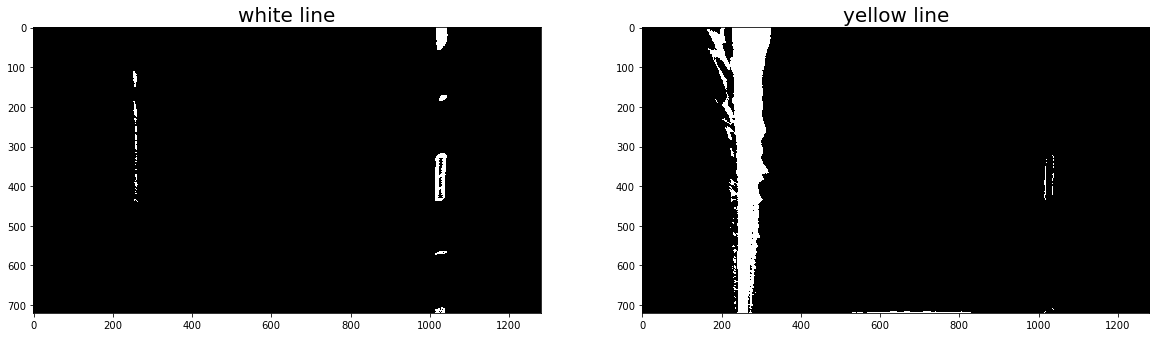

In [14]:
w_lower = (0, 180, 0)
w_upper  = (200, 250, 250)
y_lower = (0, 80, 20)
y_upper  = (60, 230, 255)

# Visualize 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

white = hls_prm_adj_proc(hls, w_lower, w_upper)
ax1.imshow(white, cmap='gray') 
ax1.set_title('white line', fontsize=20)

yellow = hls_prm_adj_proc(hls, y_lower, y_upper)
ax2.imshow(yellow, cmap='gray') 
ax2.set_title('yellow line', fontsize=20)

##### Threshold processing of gradient and its direction

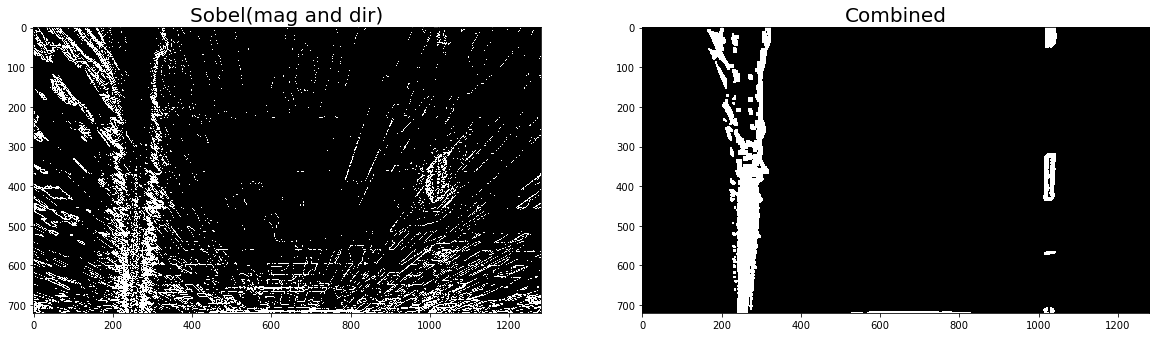

In [15]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Gradient(mag and angle) threshold  
sobel_mag_th = (10, 250)
sobel_ang_th = (0, 1.4)
th_gradient = det_lines_by_sobel(hls, sobel_mag_th, sobel_ang_th)

ax1.imshow(th_gradient, cmap='gray') 
ax1.set_title('Sobel(mag and dir)', fontsize=20)

# combine process
th_color = white | yellow
# combine results of color and sobel
combined = combine_color_and_gradient(th_color, th_gradient)

ax2.imshow(combined, cmap='gray') 
ax2.set_title('Combined', fontsize=20)

### Pipeline processing

For each process threshold, the result determined in the previous item was used.

In [16]:
# pipeline process for reading raw images and returning a binary image including the identified lane lines
def pipeline(img):

    # Undistort
    undistort_img = undistort(img)
    
    # Perspective Transform
    warp_img, M, Minv = exec_warp(undistort_img, src, dst) 
   
    # threshold for color(hls)
    # for while lines
    w_low_th = (0, 180, 0)
    w_up_th  = (200, 250, 250)
    # for yellow lines
    y_low_th = (0, 80, 20)
    y_up_th  = (60, 230, 255)       
    th_color = det_lines_by_hls_color(warp_img, w_low_th, w_up_th, y_low_th, y_up_th)

    # Gradient(mag and angle) threshold  
    sobel_mag_th = (10, 250)
    sobel_ang_th = (0, 1.4)      
    th_gradient = det_lines_by_sobel(warp_img, sobel_mag_th, sobel_ang_th)

    # combine results of color and grad
    combined = combine_color_and_gradient(th_color, th_gradient)

    return combined, Minv, warp_img, undistort_img


### Resultｓ of applying pipeline processing to all test images

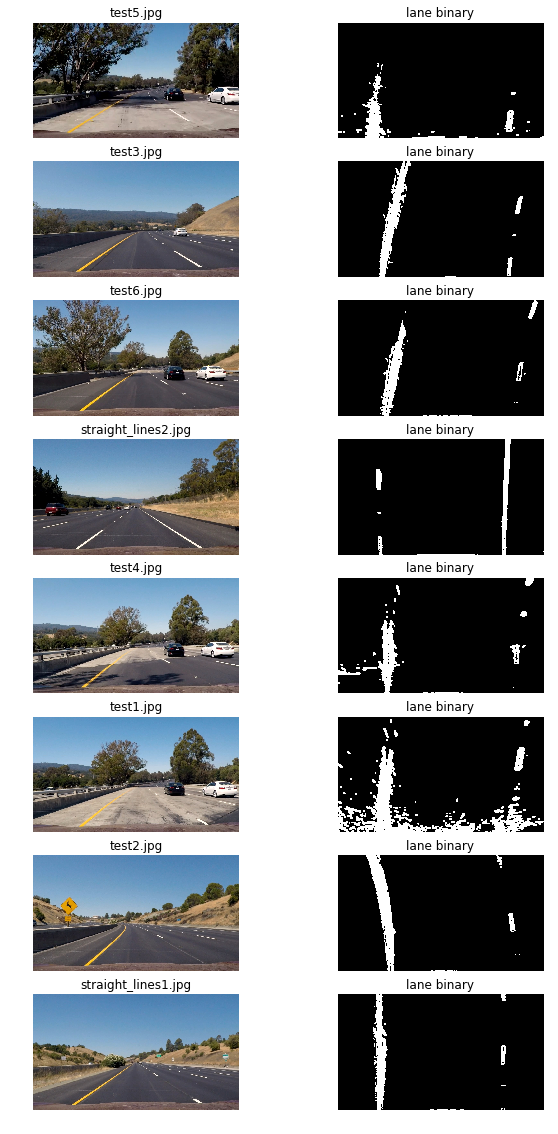

In [17]:
# Vizualize results of test_images
images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(10, 20))
#print(len(images))
for i, image in enumerate(images):   
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv, _, _= pipeline(img)    

    plt.subplot(len(images), 2, i*2 + 1)
    plt.imshow(img) 
    plt.axis('off')
    plt.title(os.path.basename(image))
 
    plt.subplot(len(images), 2, i*2 + 2)
    plt.imshow(img_bin, cmap='gray') 
    plt.axis('off')
    plt.title("lane binary")
 

### Polyfit processing by using Sliding windows

In [18]:
def polyfit_using_sliding_win(img):
    """
    A lecture on "Line discovery" was quoted. 
    
    """
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint     

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100#80
    # Set minimum number of pixels found to recenter window
    minpix = 20 #20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin       
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    visualization_data = (rectangle_data, histogram) # Store window and histgram data
    candidate_points =(leftx, lefty, rightx, righty) # Store approximate candidate points
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, candidate_points

Visualize sliding window polyfit on example image

(720, 0)

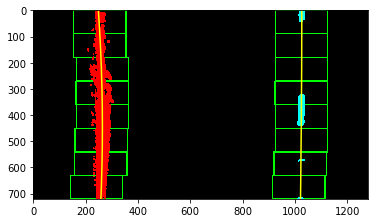

In [19]:
# Fit line by using sliding windows
sampleImage = cv2.imread('./test_images/straight_lines1.jpg')
sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)
sampleImage = undistort(sampleImage)
sampleImage_bin, Minv, _, _ = pipeline(sampleImage)
plt.imshow(sampleImage, cmap='gray')

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, _ = polyfit_using_sliding_win(sampleImage_bin)

h = sampleImage.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((sampleImage_bin, sampleImage_bin, sampleImage_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, sampleImage_bin.shape[0]-1, sampleImage_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 4) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 4) 

# Identify the x and y positions of all nonzero pixels in the image
nonzero = sampleImage_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)

(0, 1280)

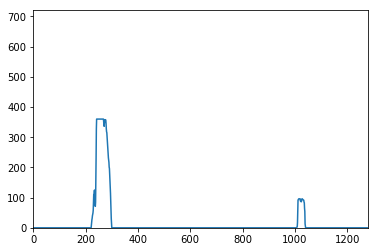

In [20]:
# Visialize histogram from sliding window polyfit processing for example image
plt.plot(histogram)
plt.ylim(0, 720)
plt.xlim(0, 1280)

### Polyfit Using Fit from Prev. Frame
*If the lane was undetected 1 frame ago, execute the sliding window. Otherwise, the search range is determined from the best fit result of past frames.*

In [21]:
def polyfit_using_prev_result(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_prev[0]*ploty**2 + left_fit_prev[1]*ploty + left_fit_prev[2]
    right_fitx = right_fit_prev[0]*ploty**2 + right_fit_prev[1]*ploty + right_fit_prev[2]

    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    visualization_data = (left_line_pts, right_line_pts)
    candidate_points =(leftx, lefty, rightx, righty)
 
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, visualization_data, candidate_points

(720, 0)

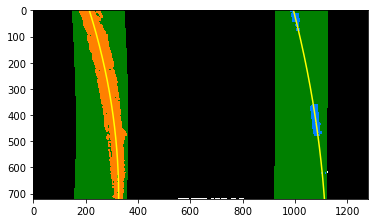

In [22]:
# Example of display of approximation using previous fit result
# curr:test2.jpg
# prev:straight_lines1.jpg(fit OK)
sampleImage2 = cv2.imread('./test_images/test2.jpg')
sampleImage2 = cv2.cvtColor(sampleImage2, cv2.COLOR_BGR2RGB)
sampleImage2_bin, Minv, _, _ = pipeline(sampleImage2)  

margin = 100

# extract current fit pixels info from prev fit info
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2, _, _= polyfit_using_prev_result(sampleImage2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, sampleImage2_bin.shape[0]-1, sampleImage2_bin.shape[0] )

# Processing assuming the previous fit result
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Processing assuming the current fit result by using prev-fit infomation
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((sampleImage2_bin, sampleImage2_bin, sampleImage2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = sampleImage2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Process of acquiring information for calculating curvature

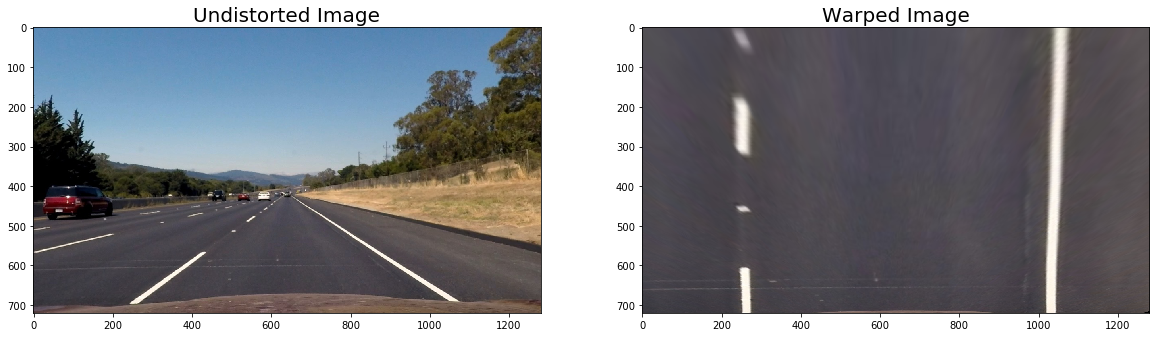

In [23]:
# test process waped processing
lanesample = cv2.imread('./test_images/straight_lines2.jpg')
lanesample = cv2.cvtColor(lanesample, cv2.COLOR_BGR2RGB)
lanesample_undistort = undistort(lanesample)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(lanesample_undistort)
ax1.set_title('Undistorted Image', fontsize=20)

lane_warp, M, Minv = exec_warp(lanesample_undistort, src, dst)
ax2.imshow(lane_warp)
ax2.set_title('Warped Image', fontsize=20)

For correspondence between images and real space, the following images are used.
The width of the lane in real space is 3.7 m. On the other hand, the measurement result in the image is 764 pixels. The length of the lane in real space is 3 m. On the other hand, the measurement result in the image is 115 pixels. Using this measurement result, correspondence between the real space and the image was made.

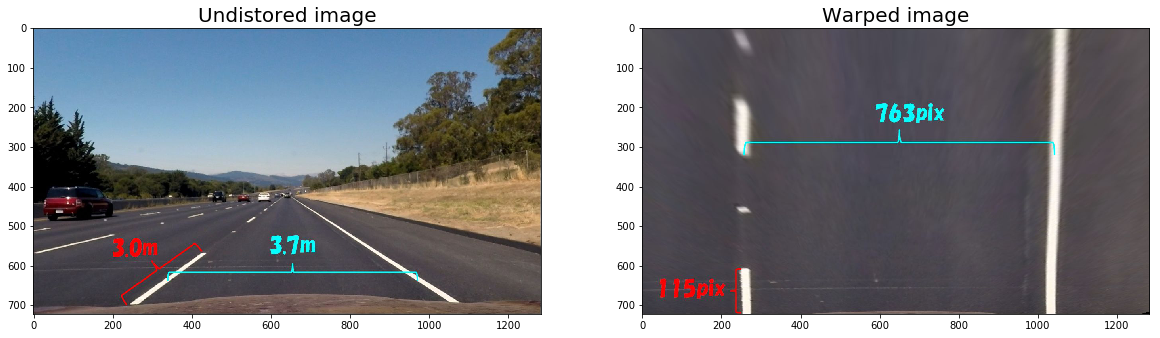

In [24]:
# Display an image for calculating the lane width and length on the image
norm = cv2.imread('./output_images/normal_view.jpg')
norm = cv2.cvtColor(norm, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Visualize normal view image
ax1.imshow(norm)
ax1.set_title('Undistored image', fontsize=20)

# Visualize ipm image
ipm = cv2.imread('./output_images/ipm.jpg')
ipm = cv2.cvtColor(ipm, cv2.COLOR_BGR2RGB)
ax2.imshow(ipm)
ax2.set_title('Warped image', fontsize=20)


### Left and right Radius of Curvature and Distance from Lane Center Calculation

In [25]:
# calculate radius of curvature and distance from lane center 
# The correspondence between the real space and the image distance was the result measured 
# by the previous item.
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/763    # meters per pixel in x dimension
    ym_per_pix = 3.0/115    # meters per pixel in y dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

Calculate curvature radius and distance from center for example image

In [26]:
l_rad, r_rad, d_center = calc_curv_rad_and_center_dist(sampleImage_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Left and Right Radius of curvature:', l_rad, 'm,', r_rad, 'm')
print('Distance from lane center:', d_center, 'm')

Left and Right Radius of curvature: 905.868154924 m, 7982.16117611 m
Distance from lane center: 0.000424097548942 m


### Draw the Detected Lane Back onto the Original Image

In [27]:
def draw_lane(in_img, binary_img, l_fit, r_fit, Minv):
    paint_img = np.copy(in_img)
    if l_fit is None or r_fit is None:
        return in_img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# Define y-value 
    
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(paint_img, 1, newwarp, 0.5, 0)
    
    return result

Draw detected lane onto example image

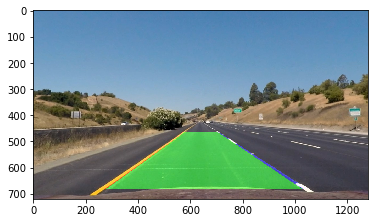

In [28]:
sampleImage_out1 = draw_lane(sampleImage, sampleImage_bin, left_fit, right_fit, Minv)
plt.imshow(sampleImage_out1)

### Draw Curvature Radius and Distance from Center Data onto the Original Image

In [29]:
def draw_data(in_img, l_curve, r_curve, center_dist, left_fit, right_fit):
    paint_img = np.copy(in_img)
    h = in_img.shape[0]

    font = cv2.FONT_HERSHEY_COMPLEX

    text = 'L_Radius of Curvature: ' + '{:04.2f}'.format(l_curve) + '[m]'
#    cv2.putText(paint_img, text, (20,50), font, .8, (10,10,10), 5, cv2.LINE_AA)
    cv2.putText(paint_img, text, (20,50), font, 1, (255,255,0), 1, cv2.LINE_AA)
    
    text = 'R_Radius of Curvature: ' + '{:04.2f}'.format(r_curve) + '[m]'
#    cv2.putText(paint_img, text, (20,80), font, 0.8, (10,10,10), 5, cv2.LINE_AA)
    cv2.putText(paint_img, text, (20,80), font, 1, (255,255,0), 1, cv2.LINE_AA)
    
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is '+'{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
#    cv2.putText(paint_img, text, (20,110), font, .8, (10,10,10), 5, cv2.LINE_AA)
    cv2.putText(paint_img, text, (20,110), font, 1, (255,255,0), 1, cv2.LINE_AA)
    
    
    font = cv2.FONT_HERSHEY_COMPLEX | cv2.FONT_ITALIC
    if left_fit is not None:
        text = 'L_fit: ' + ' {:0.6f}'.format(left_fit[0]) + ' {:0.4f}'.format(left_fit[1]) + ' {:0.3f}'.format(left_fit[2])
    else:
        text = 'L_fit: None'

#    cv2.putText(paint_img, text, (20,140), font, .7,(10,10,10), 3, cv2.LINE_AA)    
    cv2.putText(paint_img, text, (20,140), font, 1,(0,255,0), 1, cv2.LINE_AA)        

    if right_fit is not None:
        text = 'R_fit: ' + ' {:0.6f}'.format(right_fit[0]) + ' {:0.4f}'.format(right_fit[1]) + ' {:0.3f}'.format(right_fit[2])
    else:
        text = 'R_fit: None'

#    cv2.putText(paint_img, text, (20,170), font, .7,(10,10,10), 3, cv2.LINE_AA)    
    cv2.putText(paint_img, text, (20,170), font, 1,(0,255,0), 1, cv2.LINE_AA)  
    
    return paint_img

Write data onto example image

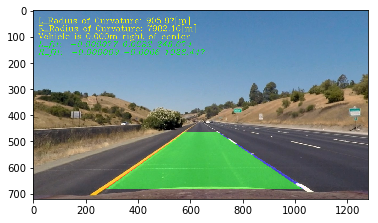

In [30]:
sampleImage_out2 = draw_data(sampleImage_out1, l_rad, r_rad, d_center, left_fit, right_fit)
plt.imshow(sampleImage_out2)

### Define a Line Class for Storing  Line Data

In [31]:
# Define a class to receive the characteristics of each line detection
class CLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    
    def UpdateInfo(self, fit, inds):
        # update line fit information 
        if fit is not None:
            if self.best_fit is not None:
                # Calculate difference with best fit
                self.diffs = abs(fit-self.best_fit)
            
            coef = 2.0  # A coefficient for adjusting the difference comparison information
            # Results where the difference from the best fit is larger than the threshold value are invalidated.
            if (self.diffs[0] > 0.001 * coef or self.diffs[1] > 1.0 * coef or self.diffs[2] > 100. * coef):
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 10:
                    # The latest fit information for the past ten lines is saved.
                    self.current_fit = self.current_fit[len(self.current_fit)-10:]
                    
                self.best_fit = np.average(self.current_fit, axis=0)

        # When lane is not detected, past information is deleted. However, only one remains.
        else:
            self.detected = False
            if len(self.current_fit) > 1:
                # exclude the oldest information
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                # Recalculate best fit
                self.best_fit = np.average(self.current_fit, axis=0)                   


### Define Complete Image Processing Pipeline

In [32]:
def main_process(in_img):

    img_bin, Minv, ipm, undist = pipeline(in_img)
    1
    rect_win = None         # sliding windows

    # points of left and right lanes
    left_line_pts = None
    right_line_pts = None
    
    # coef for adjust
    coef = 2.0
       
    # When left and right lanes are detected, polyfit using past information is executed. 
    # If either is not detected, execute polyfit by using sliding windows.
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, visualization, candidate_points = polyfit_using_sliding_win(img_bin)
        rect_win = visualization[0]
        l_x =candidate_points[0]
        l_y =candidate_points[1]
        r_x =candidate_points[2]
        r_y =candidate_points[3]

    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds, visualization, candidate_points = polyfit_using_prev_result(img_bin, l_line.best_fit, r_line.best_fit)
        # Draw the lane onto the warped blank image
        left_line_pts = np.int_([visualization[0]])
        right_line_pts = np.int_([visualization[1]])  
        l_x =candidate_points[0]
        l_y =candidate_points[1]
        r_x =candidate_points[2]
        r_y =candidate_points[3]
                   
    l_line.UpdateInfo(l_fit, l_lane_inds)
    r_line.UpdateInfo(r_fit, r_lane_inds)
    
    #If there is a best fit, the lane is displayed, otherwise it is not drawn.
    if l_line.best_fit is not None and r_line.best_fit is not None:
        out_img1 = draw_lane(undist, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        l_rad, r_rad, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        out_img = draw_data(out_img1, l_rad, r_rad, d_center, l_fit, r_fit)
    else:
        out_img = undist
    
    # select display mode
    #MultiScreen = False
    MultiScreen = True

    if MultiScreen == True:

        # create multi screen
        multi_img = np.zeros((720,1280,3), dtype=np.uint8)
        multi_img=out_img      
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        img_bin2 = np.copy(img_bin)
        window_img = np.zeros_like(img_bin2)

        # The screen at the top right
        # Line candidate points and best fit
        if(rect_win is not None):
            # draw sliding window
            for rect in rect_win:
                # Draw the windows on the visualization image
                cv2.rectangle(img_bin2,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
                cv2.rectangle(img_bin2,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2)
            
        else:#  in the case of fitting by using prev fit info.
            cv2.fillPoly(window_img, left_line_pts, (0,255, 0))
            cv2.fillPoly(window_img, right_line_pts, (0,255, 0))
            img_bin2 = cv2.addWeighted(img_bin2, 1, window_img, 0.5, 0)
           
        # Candidate points of line
        img_bin2[l_y,l_x] = [255, 0, 0]    
        img_bin2[r_y,r_x] = [0, 0, 255] 
        
        # draw lines onto binary warped imag
        img_bin2 = draw_fit_on_ipm(img_bin2, l_line.best_fit, (255,255,0))
        img_bin2 = draw_fit_on_ipm(img_bin2, r_line.best_fit, (255,255,0))          
        resized_img_bin = cv2.resize(img_bin2,(640//2,360//2))
        multi_img[0:360//2,1280//2+320:1280,:] = resized_img_bin
        
        # The upper right screen in the middle      
        multi_img[0:360//2,640:1280//2+320, :] = cv2.resize(ipm,(640//2,360//2))        

        out_img = multi_img

    return out_img

##### draw best fit onto bird's view image

In [33]:
def draw_fit_on_ipm(img, fit, draw_color):
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(img, np.int32([pts]), isClosed=False, color=draw_color, thickness=10)
    
    return img

### Results

#### Processing of project video

In [34]:
# initialize Line Class
l_line = CLine()
r_line = CLine()

# load video data and pipeline processing(project_video)
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')

processed_video = video_input.fl_image(main_process)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:57<00:00,  5.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 32s, sys: 12.6 s, total: 10min 45s
Wall time: 2min 58s


#### Processing of challeng video

In [35]:
# initialize Line Class
l_line = CLine()
r_line = CLine()

# load video data and pipeline processing(challenge_video)
video_output = 'challenge_video_output.mp4'
video_input = VideoFileClip('challenge_video.mp4')

processed_video = video_input.fl_image(main_process)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:23<00:00,  6.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 18s, sys: 4.77 s, total: 5min 22s
Wall time: 1min 23s


#### Processing of harder challenge video

In [36]:
# initialize Line Class
l_line = CLine()
r_line = CLine()

# load video data and pipeline processing(harder_challenge_video)
video_output = 'harder_challenge_video_output.mp4'
video_input = VideoFileClip('harder_challenge_video.mp4')

processed_video = video_input.fl_image(main_process)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:47<00:00,  7.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 9min 56s, sys: 11.4 s, total: 10min 8s
Wall time: 2min 47s


#### End of file